In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *
from collections import Counter
import pandas as pd
import csv
import os.path
import scipy
from scipy.optimize import minimize

In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


In [3]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

In [4]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params): # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    
# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

def CVaRsamp(params, alpha=1, n=100):#n=antal samples
    
    probs = get_probs(params)  # hämta sannolikhetsfördelningen (matris, första värdet är p(00000000), andra är p(00000001) osv)
    
    index_samples= np.random.choice(np.arange(len(probs), dtype=int), size=n, replace=True,p=probs)  # tar n samples av probs, ger skum lista med index motsvarande konfiguration (index 0 är tillståndet 00000000, index 1 =00000001 osv)
    energy_of_samples=energies_of_set(protein.get_solution_set(), H_cost,8) [index_samples]  #ger en lista där index i index_samples är utbytta mot deras motsvarande energi. 
    sorted_energy_samples=sort_over_threshhold(energy_of_samples,-10)[0] #sorterar hela energilistan
    K=int(alpha*n) #antal samples att ta väntevärde över. 
    summa=sum(sorted_energy_samples[:K]) #summera de K minsta energierna.
    expvalue=np.float64(summa/K)
    
    return expvalue

In [33]:
ga_count = -1
be_count = -1
ac = -1

a = [0.05,0.1,0.25,1]

values = np.ones((400,100))

for alphas in a:
    ac += 1
    for ga in np.linspace(0, 2*np.pi, 10):
        ga_count += 1
        for be in np.linspace(0, 2*np.pi, 10):
            be_count += 1
            list_ = []
            params = [[ga],[be]]
            for i in range(100):
                values[100*ac + np.mod(ga_count*10,100) + np.mod(be_count,10),i] = CVaRsamp(params, alpha=alphas, n=32)
            print(100*ac + np.mod(ga_count*10,100) + np.mod(be_count,10))

print(values)
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<function matplotlib.pyplot.show(close=None, block=None)>

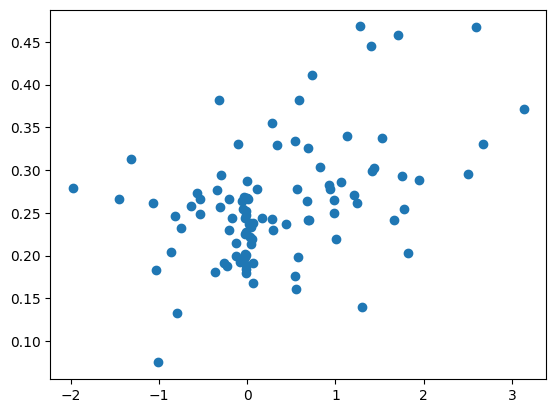

In [37]:
vars_ = []
avgs_ = []
for i in range(300,400):
    vars_.append(np.var(values[i,:]))
    avgs_.append(np.average(values[i,:]))
    

plt.plot(avgs_,vars_,'o')
plt.show

In [ ]:
data = {
      "CVaR cost": cost_list_list,
      "Ground state probability": prob_list_list,
      "Iterations needed": iter_needed_list
    }
    
    var_name = "data_for_alpha_%s" % a
    data_library[var_name] = data
    
        

for index, alpha_data in enumerate(data_library, start=0):
    
    df=pd.DataFrame(data_library[alpha_data])
    
    sek=''
    for i in sequence: #translates 1001 to HPPH etc
        if i==1: 
            sek+='H'
        else: 
            sek+='P'
            
    #filens titel
    parms=('sekvens: ' + str(sek) + ', gridsize: ' + str(L1)+'X'+str(L2) + ', p: ' + str(len(initial_params[0])) + 
           ', alpha: ' + str(alphas[index]) + ', Optimizer: COBYLA, tol: ' + str(tolerance) + ', initial parameters: '
          + str(initial_params[0]) + ', ' + str(initial_params[1]) + ', samples: ' + str(num_of_samples) + ', number of tests: ' + str(number_of_tests)) 

    #checks if file already exists and if so adds 1 to the end of the file name 8)
    while os.path.isfile('pettson_data_test/'+str(sek)+'/'+ str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv'):
        if parms[-1]!=1:
            parms+=(':1')
        else:
            parms[-1]+=1

    df.to_csv('pettson_data_test/'+str(sek)+'/'
              + str(L1)+'X'+str(L2)+'/' + str(parms) + '.csv', 
              index=False, header = True) #save in the right folder (pettson -> sekvens -> 2X2 )

In [40]:
df= pd.DataFrame(values)
df.to_csv('pettson_data_test/HPPH/2X2/samplingtest.csv', 
              index=False, header = False) #save in the right folder (pettson -> sekvens -> 2X2 )